# Second empirical example for optimization of enzyme reaction rates

### Popular choices to model the reaction rate in dependency of T
#### 1. Ratkowksy model up to $T_{opt}$ and Gaussian model from there

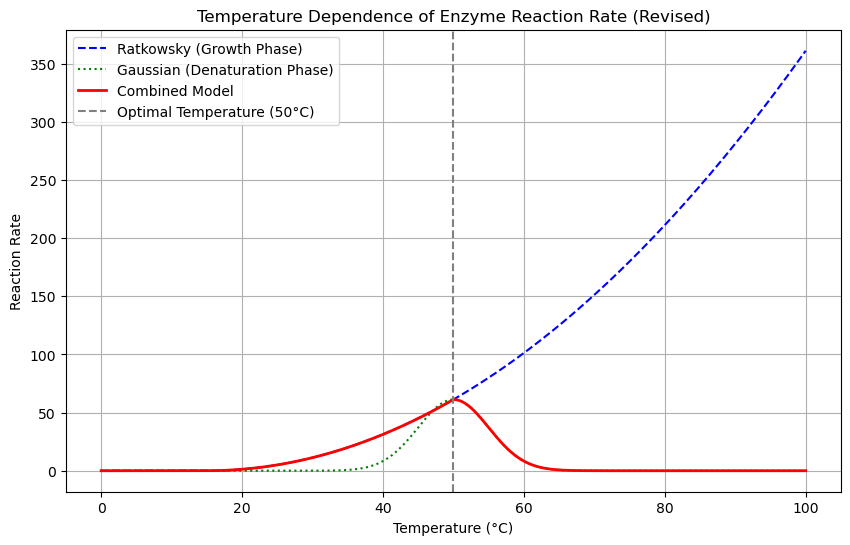

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Temperature range
T = np.linspace(0, 100, 500)  # Temperature range (0-100°C)

# Ratkowsky equation parameters
T_min = 15   # Minimum temperature for activity
b = 0.05    # Growth constant

# Gaussian model parameters
T_opt = 50  # Optimal temperature
sigma = 5  # Spread of the Gaussian

# Compute the Ratkowsky curve (valid for T > T_min)
ratkowsky_curve = np.where(T > T_min, b * (T - T_min)**2, 0)

# Determine the Gaussian scale at the transition point
r_opt = b * (T_opt - T_min)**2  # Value of Ratkowsky curve at T_opt

# Compute the Gaussian curve (scaled to match Ratkowsky at T_opt)
gaussian_curve = r_opt * np.exp(-(T - T_opt)**2 / (2 * sigma**2))

# Combine the two for an empirical bell-shaped curve
combined_curve = np.where(T < T_opt, ratkowsky_curve, gaussian_curve)

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(T, ratkowsky_curve, label="Ratkowsky (Growth Phase)", linestyle="--", color="blue")
plt.plot(T, gaussian_curve, label="Gaussian (Denaturation Phase)", linestyle=":", color="green")
plt.plot(T, combined_curve, label="Combined Model", linewidth=2, color="red")
plt.axvline(T_opt, color="gray", linestyle="--", label=f"Optimal Temperature ({T_opt}°C)")

plt.title("Temperature Dependence of Enzyme Reaction Rate (Revised)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction Rate")
plt.legend()
plt.grid()
plt.show()

#### 2. Alternative: Extended Ratkowsky model

$k = b * \left(T - T_\mathrm{min}\right)^2 \cdot \left(1 - e^{c \cdot (T - T_\mathrm{max})}\right),$ 

$k=0$ for $T>T_\mathrm{max}$ or $T<T_\mathrm{min}$


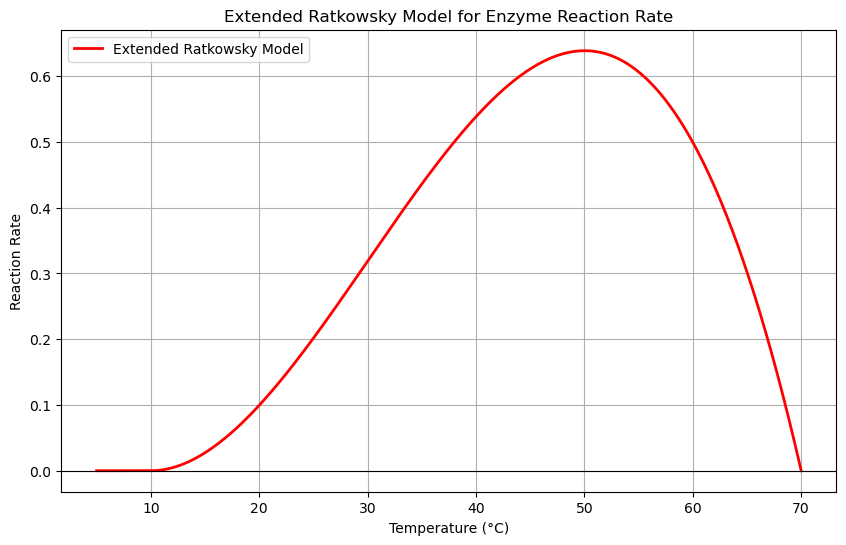

In [2]:
import matplotlib.pyplot as plt

from utils import ratkowsky_curve

# Plotting the Ratkowsky curve over a temperature range
T_min = 10    # Minimum temperature for activity
T_max = 70   # Maximum temperature (activity zero greater or equal to this)
T = np.linspace(5, T_max, 500)  # Temperature range between 5 and T_max
b = 0.1   # Growth constant
c = 0.0002    # Decay constant

extended_ratkowsky_curve = ratkowsky_curve(T, T_min=T_min, T_max=T_max, b=b, c=c)

plt.figure(figsize=(10, 6))
plt.plot(T, extended_ratkowsky_curve, label="Extended Ratkowsky Model", color="red", linewidth=2)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Extended Ratkowsky Model for Enzyme Reaction Rate")
plt.xlabel("Temperature (°C)")
plt.ylabel("Reaction Rate")
plt.legend()
plt.grid()
plt.show()


## Case study: Optimization of reaction rates

The enzymes follows a first-order kinetic model. The reaction rate is dependent on the temperature according to the extended Ratkowksy model, which is however unknown beforehand.

### Step 1: Generate mock data.
Generate data from two batch experiments, each having three measurements (e.g. shake flaks in incubators at different temperatures). Let's first not assume batch effects.

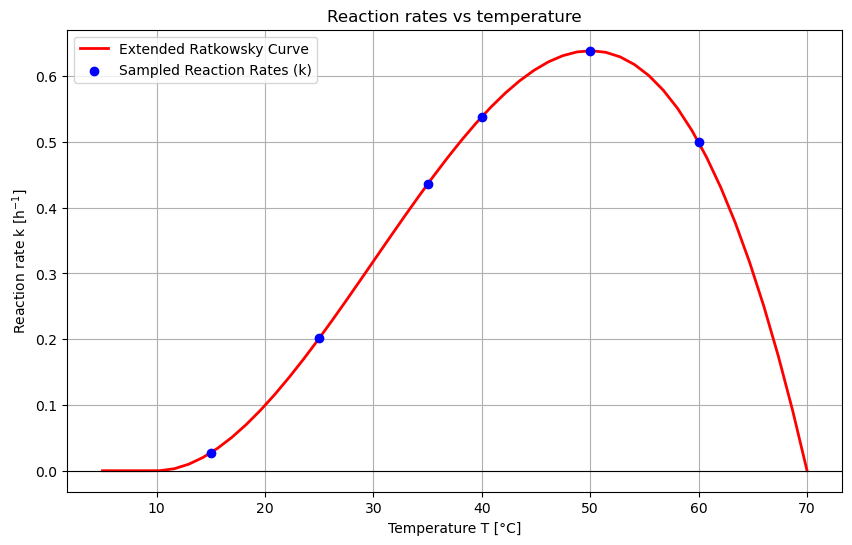

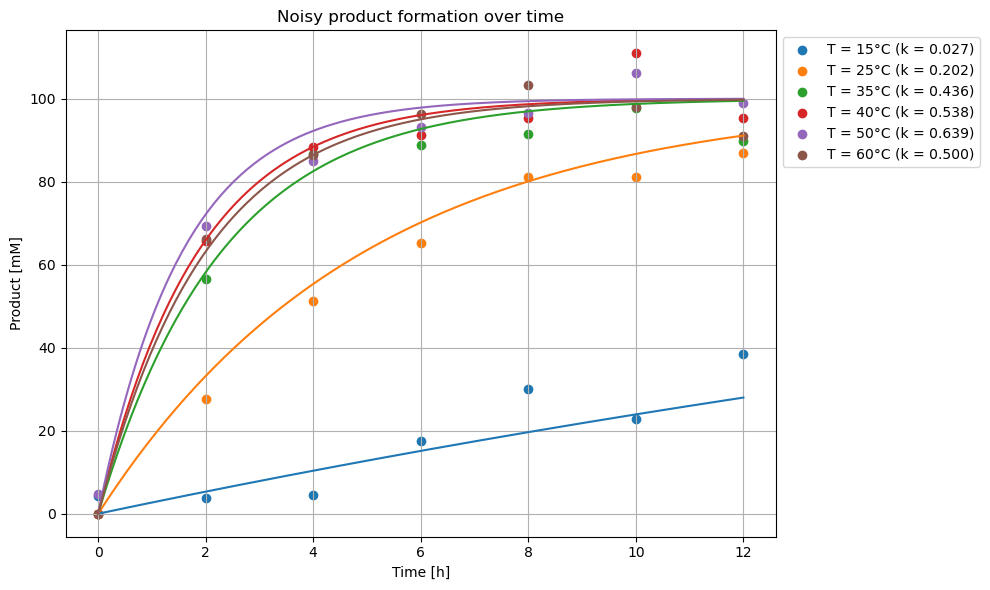

In [3]:
from utils import extract_high_res_P_series, get_P_samples


# Fixed sampled temperatures (°C)
T_sampled = np.array([15, 25, 35, 40, 50, 60])

# Compute reaction rates (k) for sampled temperatures
reaction_rates = ratkowsky_curve(T_sampled, T_min=T_min, T_max=T_max, b=b, c=c)

# Generate the full dependency curve of k on T for plotting
T_full = np.linspace(5, T_max, 50)  # Fine-grained temperature range for the curve
k_full = ratkowsky_curve(T_full, T_min=T_min, T_max=T_max, b=b, c=c)

# Time sampling: every 2 hours, total 12 hours
time = np.arange(0, 13, 2)  # Time in hours (0, 2, 4, ..., 12)

# Initial substrate concentration (mM)
S0 = 100

# Compute product formation (P) over time for each temperature and reaction rate
P_samples = {}
for rate in reaction_rates:
    P_noisy = get_P_samples(
        k=rate,
        S0=100,
        time=time
    )
    P_samples[rate] = P_noisy


# Plot Reaction Rate vs Temperature with Dependency Curve
plt.figure(figsize=(10, 6))
plt.plot(T_full, k_full, color="red", label="Extended Ratkowsky Curve", linewidth=2)
plt.scatter(T_sampled, reaction_rates, color="blue", label="Sampled Reaction Rates (k)", zorder=3)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Reaction rates vs temperature")
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.legend()
plt.grid()
plt.show()

# Plot Product Formation Over Time
plt.figure(figsize=(10, 6))

# Plot noisy product formation curves
for i, k in enumerate(P_samples.keys()):
    P_noisy = P_samples[k]
    plt.scatter(time, P_noisy, marker="o", label=f"T = {T_sampled[i]}°C (k = {reaction_rates[i]:.3f})")
    plt.plot(*(extract_high_res_P_series(time, k)))

plt.title("Noisy product formation over time")
plt.xlabel("Time [h]")
plt.ylabel("Product [mM]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()


### Step 2: Prepare the data as a numpy array with shape (catalyst, time points)

In [4]:
observed = []
for tseries in P_samples.values():
    observed.append(list(tseries))
observed = np.array(observed)
print(observed.shape)

(6, 7)


### Step 3: Build the PyMC model

In [5]:
import pymc as pm
import pytensor.tensor as pt

coords = {
    "catalyst": np.arange(6),
    "time": time,
}

with pm.Model(coords=coords) as pmodel:
    # k = pm.HalfNormal("k", dims="catalyst")
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    S_0 = pm.Normal("S0", mu=100, sigma=5)
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_t", X=T_sampled[:, None], jitter=1e-4)
    P = pm.Deterministic("P", S_0 * (1 - pt.exp(-k[:, None] * time[None, :])), dims=("catalyst", "time"))
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed,
        dims=("catalyst", "time")
    )
    trace = pm.sample(5000, tune=1000, chains=8, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, k_over_t_rotated_]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 20 seconds.


### Step 4: Analyze the model

#### Trace plot

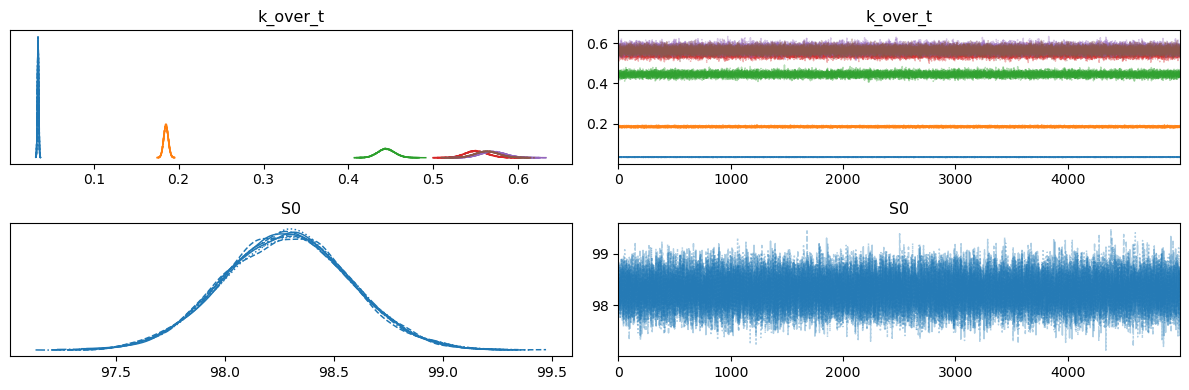

In [6]:
from matplotlib import pyplot as plt
pm.plot_trace(trace, var_names=["k_over_t", "S0"])
plt.tight_layout()

#### Posterior for GP

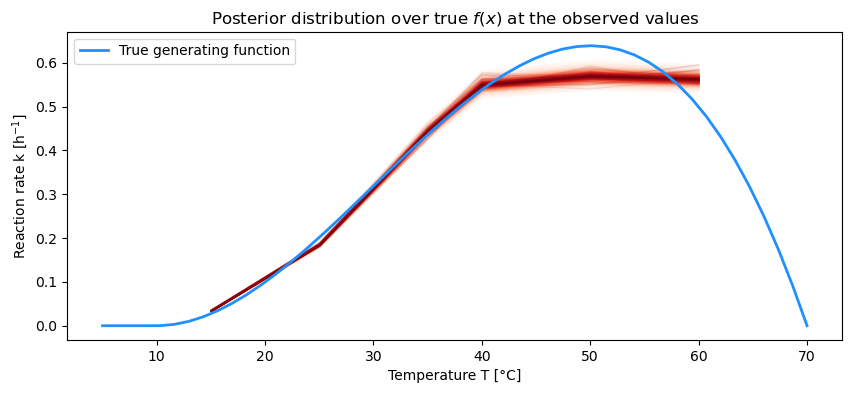

In [7]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist
import arviz as az

f_post = az.extract(trace, var_names="k_over_t").transpose("sample", ...)
plot_gp_dist(ax, f_post, T_sampled[:, None])


# plot the data and the true latent function
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

#### Compute posterior predictive, which can also be used for further Bayesian optimization

In [8]:
with pmodel:
    # add the GP conditional to the model, given the new X values
    f_pred = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace.extend(pm.sample_posterior_predictive(trace, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

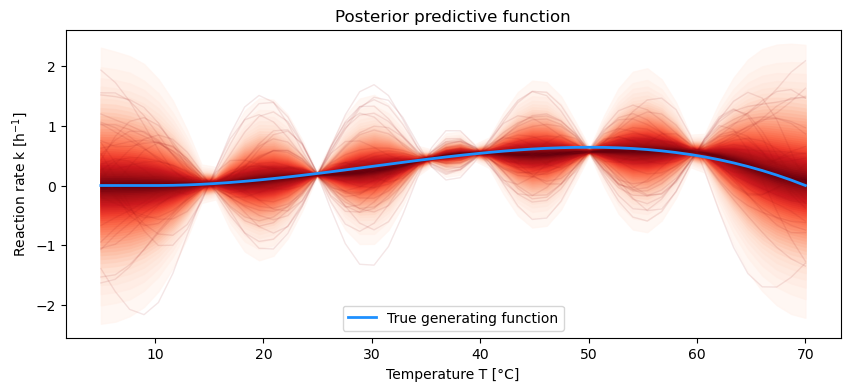

In [9]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred = az.extract(trace.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

## Case study 2: Base case plus fitting the length scale and scaling factor

In [10]:
coords = {
    "catalyst": np.arange(6),
    "time": time,
}

with pm.Model(coords=coords) as pmodel2:
    # k = pm.HalfNormal("k", dims="catalyst")
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    S_0 = pm.Normal("S0", mu=100, sigma=5)
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    ell = pm.Gamma("ell", alpha=3, beta=1)
    eta = pm.HalfNormal("eta", sigma=2)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_t", X=T_sampled[:, None], jitter=1e-4)
    P = pm.Deterministic("P", S_0 * (1 - pt.exp(-k[:, None] * time[None, :])), dims=("catalyst", "time"))
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed,
        dims=("catalyst", "time")
    )
    trace2 = pm.sample(5000, tune=5000, chains=8, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, ell, eta, k_over_t_rotated_]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 5_000 tune and 5_000 draw iterations (40_000 + 40_000 draws total) took 47 seconds.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


### Analytical plots

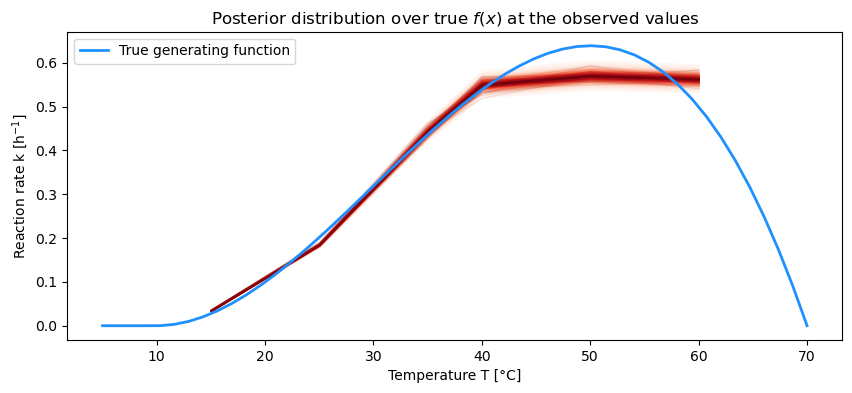

In [11]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
f_post2 = az.extract(trace2, var_names="k_over_t").transpose("sample", ...)
plot_gp_dist(ax, f_post2, T_sampled[:, None])


# plot the data and the true latent function
# ax.plot(, f_true, "dodgerblue", lw=3, label="True generating function "f"")
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

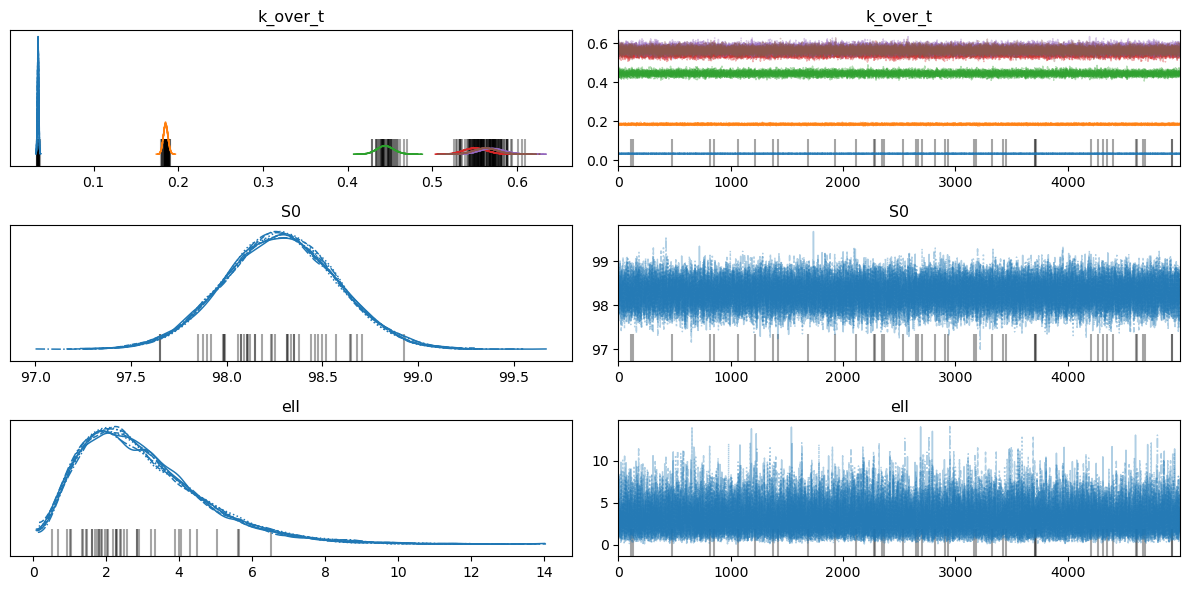

In [12]:
pm.plot_trace(trace2, var_names=["k_over_t", "S0", "ell"])
plt.tight_layout()

In [13]:
with pmodel2:
    # add the GP conditional to the model, given the new X values
    f_pred2 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace2.extend(pm.sample_posterior_predictive(trace2, var_names=["f_pred"]))

Sampling: [f_pred]


Output()

### Posterior predictive

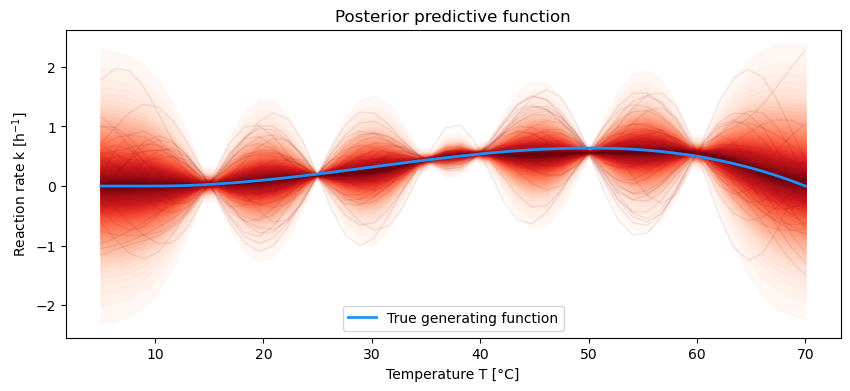

In [14]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred2, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();

#### Comparison of PP for both models

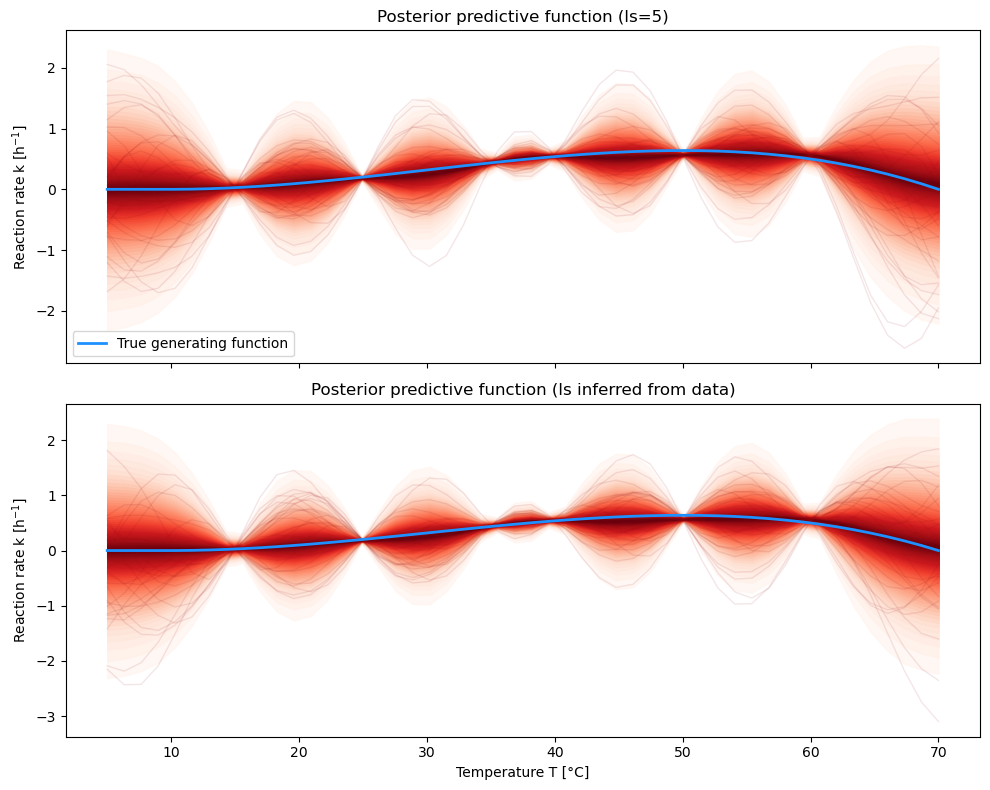

In [15]:
fig, axs = plt.subplots(figsize=(10, 8), nrows=2, sharex=True)

ax = axs[0]
f_pred = az.extract(trace.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (ls=5)")
ax.legend()

ax = axs[1]
f_pred2 = az.extract(trace2.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred2, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function (ls inferred from data)")
plt.tight_layout()
plt.show()

In [16]:
# TODO: Batch-Effekte (z.B. neuer Mastermix), Batch-Größe 3, Zeit-Delay oder ein Schüttler mit Offset -> Kolben oder andere Gefäße

## Introduction of Batch effect
### Step 1: Generate more complex data

In [17]:
import pandas as pd
shakers = [1, 2, 3, 1, 2, 3]
batches = [1, 2, 1, 1, 2, 2]
df = pd.DataFrame([], columns=["time", "batch", "device", "P", "S0", "k_true", "T"])
index = 0
T_sampled = np.array([15, 30, 30, 45, 55, 65])
S0_true = [101, 97, 101, 101, 97, 97]
true_rates = []
for i, T_value in enumerate(T_sampled):
    S0 = S0_true[i]
    k_value = ratkowsky_curve(
        T=T_value,
        T_min=T_min,
        T_max=T_max,
    )
    P_samples = get_P_samples(
        k=float(k_value),
        S0=S0,
        time=time,
    )
    true_rates.append(k_value)
    for j, P_value in enumerate(P_samples):
        index += 1
        df.loc[index] = [time[j], batches[i], shakers[i], P_value, S0, k_value, T_value]
df.set_index(["batch", "device"], inplace=True)
df



time           P   S0               k_true   T
batch device                                                
1     1          0    1.732628  101  0.02734930306157818  15
      1          2    4.304932  101  0.02734930306157818  15
      1          4   16.505794  101  0.02734930306157818  15
      1          6   11.412811  101  0.02734930306157818  15
      1          8   16.556640  101  0.02734930306157818  15
      1         10   24.841925  101  0.02734930306157818  15
      1         12   22.936296  101  0.02734930306157818  15
2     2          0    0.000000   97   0.3187234065175737  30
      2          2   45.392577   97   0.3187234065175737  30
      2          4   65.529528   97   0.3187234065175737  30
      2          6   74.240751   97   0.3187234065175737  30
      2          8   92.689794   97   0.3187234065175737  30
      2         10   99.420983   97   0.3187234065175737  30
      2         12  104.057321   97   0.3187234065175737  30
1     3          0    3.431043  101   0.3187234065175737  30
      3          2   45.272647  101   0.3187234065175737  30
      3          4   71.287053  101   0.3187234065175737  30
      3          6   89.075320  101   0.3187234065175737  30
      3          8   94.350320  101   0.3187234065175737  30
      3         10   94.307577  101   0.3187234065175737  30
      3         12  104.582199  101   0.3187234065175737  30
      1          0    6.081429  101   0.6109712988964158  45
      1          2   77.277225  101   0.6109712988964158  45
      1          4   98.533909  101   0.6109712988964158  45
      1          6   97.757975  101   0.6109712988964158  45
      1          8  105.829081  101   0.6109712988964158  45
      1         10   98.127436  101   0.6109712988964158  45
      1         12   97.552593  101   0.6109712988964158  45
2     2          0    2.415865   97   0.6065896605669674  55
      2          2   68.497963   97   0.6065896605669674  55
      2          4   86.967191   97   0.6065896605669674  55
      2          6   98.013824   97   0.6065896605669674  55
      2          8   98.932801   97   0.6065896605669674  55
      2         10  109.225864   97   0.6065896605669674  55
      2         12  103.964493   97   0.6065896605669674  55
      3          0    0.000000   97   0.3023488004040559  65
      3          2   49.735269   97   0.3023488004040559  65
      3          4   69.808970   97   0.3023488004040559  65
      3          6   86.150624   97   0.3023488004040559  65
      3          8   82.914103   97   0.3023488004040559  65
      3         10   84.204571   97   0.3023488004040559  65
      3         12   92.453658   97   0.3023488004040559  65

### Formay data as array

In [18]:
observed_bias = df.P.values.reshape((6,7))
print(observed_bias)

[[  1.73262762   4.30493224  16.50579403  11.41281149  16.55664022
   24.84192454  22.9362963 ]
 [  0.          45.39257662  65.52952765  74.24075103  92.68979382
   99.42098252 104.05732132]
 [  3.43104283  45.27264745  71.28705298  89.07532045  94.35032035
   94.3075766  104.5821986 ]
 [  6.08142924  77.27722499  98.53390895  97.75797458 105.82908096
   98.12743588  97.55259342]
 [  2.41586457  68.4979634   86.96719088  98.01382443  98.9328005
  109.22586438 103.96449265]
 [  0.          49.73526877  69.80897044  86.15062363  82.91410339
   84.20457116  92.45365814]]


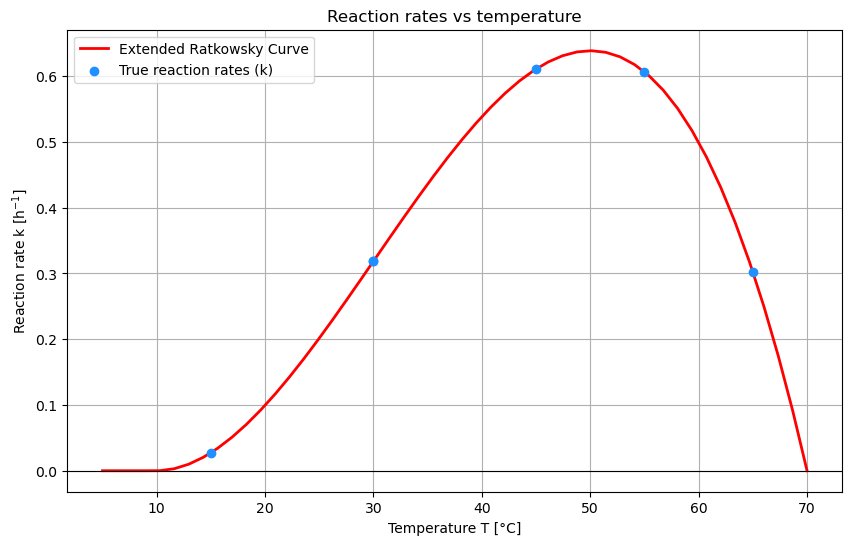

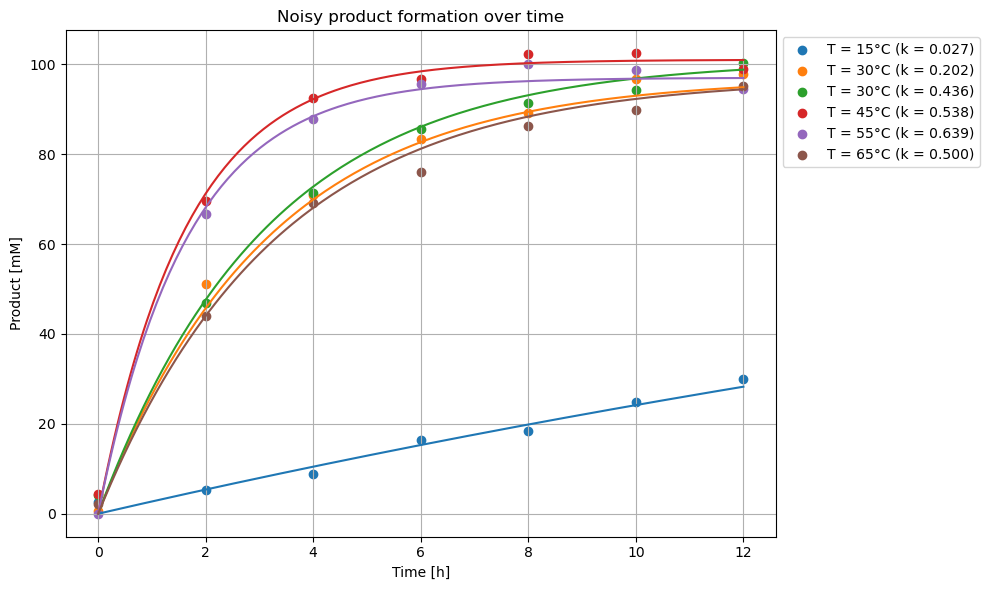

In [19]:
# Plot Reaction Rate vs Temperature with Dependency Curve
plt.figure(figsize=(10, 6))
plt.plot(T_full, k_full, color="red", label="Extended Ratkowsky Curve", linewidth=2)
plt.scatter(T_sampled, true_rates, color="dodgerblue", label="True reaction rates (k)", zorder=3)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Reaction rates vs temperature")
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.legend()
plt.grid()
plt.show()

# Plot Product Formation Over Time
plt.figure(figsize=(10, 6))

# Plot noisy product formation curves
for i, T_value in enumerate(T_sampled):
    S0 = S0_true[i]
    k_value = ratkowsky_curve(
        T=T_value,
        T_min=T_min,
        T_max=T_max
    )
    P_samples = get_P_samples(
        k=float(k_value),
        S0=S0,
        time=time,
        sigma=2,
    )
    plt.scatter(time, P_samples, marker="o", label=f"T = {T_sampled[i]}°C (k = {reaction_rates[i]:.3f})")
    plt.plot(*(extract_high_res_P_series(
        time=time,
        k=k_value,
        S0=S0,
    )))

plt.title("Noisy product formation over time")
plt.xlabel("Time [h]")
plt.ylabel("Product [mM]")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()
plt.tight_layout()
plt.show()

### Step 2: Build PyMC model with batch effect for substrate

In [20]:
coords = {
    "catalyst": np.arange(6),
    "time": time,
    "batch": [1, 2],
    "shaker": [1, 2, 3],
}

with pm.Model(coords=coords) as pmodel3:
    # k = pm.HalfNormal("k", dims="catalyst")
    temp_data = pm.Data(
        "temp_data",
        value=T_sampled,
        dims="catalyst"
    )
    S_0 = pm.Normal("S0", mu=100, sigma=1)
    S_batch = pm.Normal("S_batch", mu=0, sigma=3, dims="batch")
    S_catalyst = pm.Deterministic(
        "S_catalyst",
        pt.stack([
            S_0 + S_batch[0],
            S_0 + S_batch[1],
            S_0 + S_batch[0],
            S_0 + S_batch[0],
            S_0 + S_batch[1],
            S_0 + S_batch[1],
            ]),
        dims="catalyst"
    )
    timepoints = pm.Data(
        name="time_data",
        value=time,
        dims="time"
    )
    cov_func = pm.gp.cov.ExpQuad(1, ls=5)
    gp = pm.gp.Latent(cov_func=cov_func)
    k = gp.prior("k_over_T", X=T_sampled[:, None], jitter=1e-4, dims="catalyst")
    # k_offsets = pm.Uniform("k_offset", lower=-0.1, upper=0.1, dims="shaker")
    # k_catalyst_shaker = pm.Deterministic(
    #     "k_catalyst_shaker",
    #     pt.stack([
    #         k[0] + k_offsets[0],
    #         k[1] + k_offsets[1],
    #         k[2] + k_offsets[2],
    #         k[3] + k_offsets[0],
    #         k[4] + k_offsets[1],
    #         k[5] + k_offsets[2],
    #     ]),
    #     dims="catalyst"
    # )
    P = pm.Deterministic("P", S_catalyst[:, None] * (1 - pt.exp(-k[:, None] * time[None, :])), dims=("catalyst", "time"))
    pm.Normal(
        "likelihood",
        mu=P,
        observed=observed_bias,
        dims=("catalyst", "time")
    )
    trace3 = pm.sample(5000, tune=1000, chains=8, cores=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (8 chains in 1 job)
NUTS: [S0, S_batch, k_over_T_rotated_]


Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Sampling 8 chains for 1_000 tune and 5_000 draw iterations (8_000 + 40_000 draws total) took 61 seconds.


### Analyze model via diagnostic plots

/opt/homebrew/Caskroom/miniforge/base/envs/bo_examples311/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


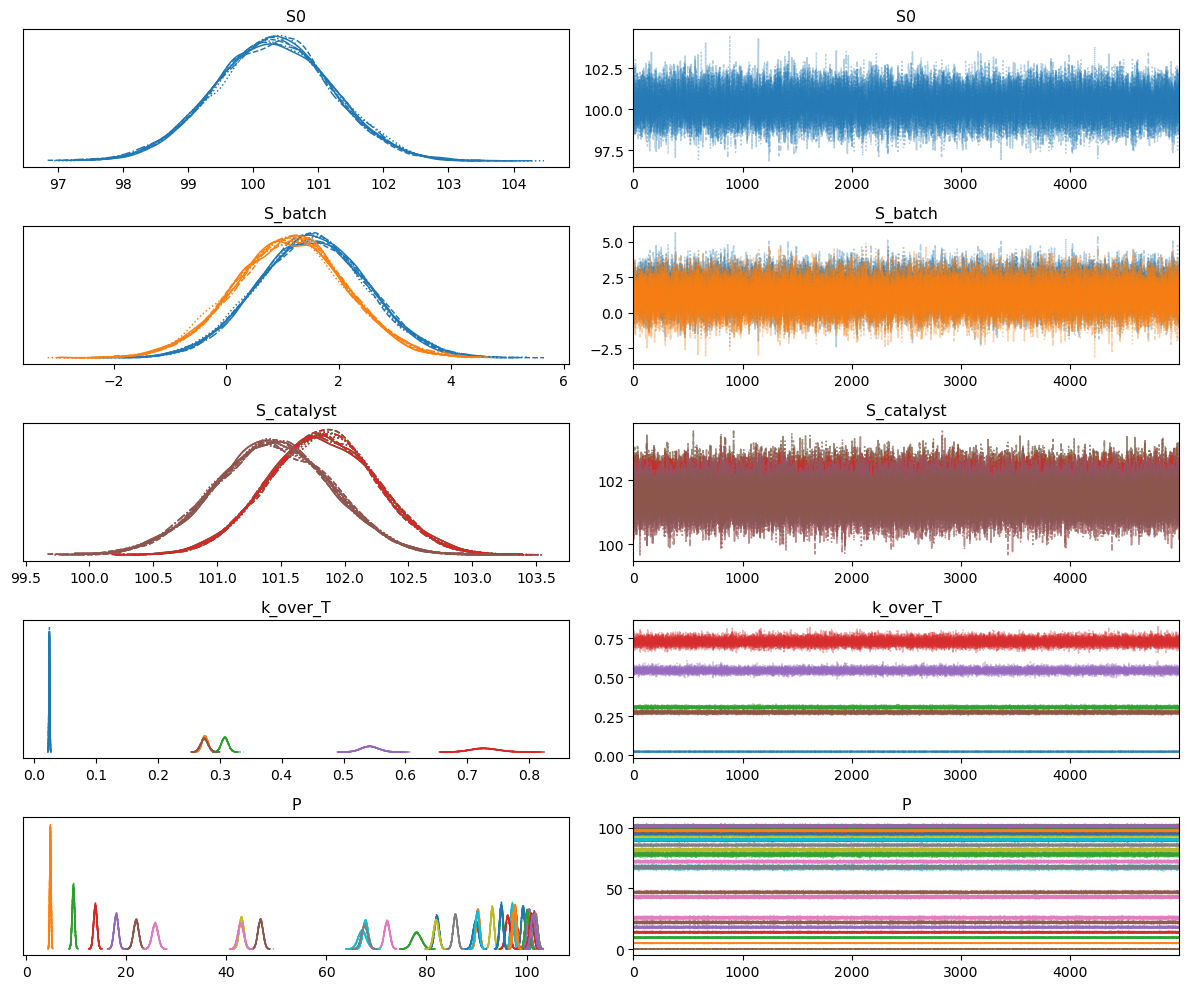

In [21]:
pm.plot_trace(
    trace3,
    var_names=[
        "S0", 
        "S_batch",
        "S_catalyst",
        "k_over_T",
        "P",
    ]
)
plt.tight_layout()

In [22]:
with pmodel3:
    # add the GP conditional to the model, given the new X values
    f_pred3 = gp.conditional("f_pred", T_full[:, None], jitter=1e-4)

    # Sample from the GP conditional distribution
    trace3.extend(pm.sample_posterior_predictive(trace2, var_names=["f_pred"]))

Sampling: [f_pred, k_over_T_rotated_]


Output()

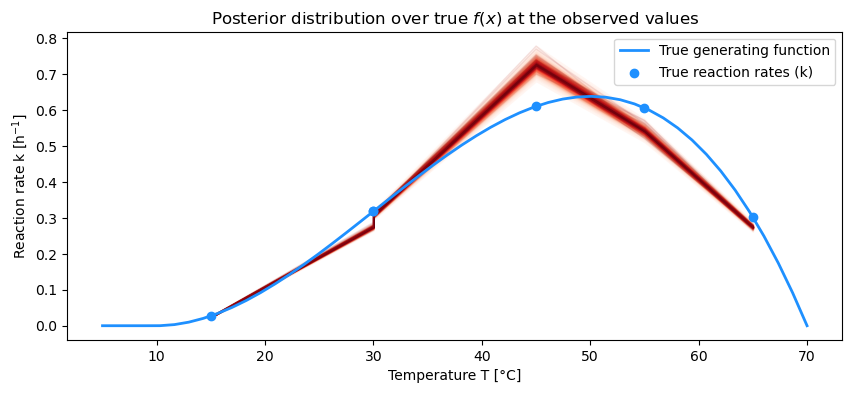

In [23]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
f_post3 = az.extract(trace3, var_names="k_over_T").transpose("sample", ...)
plot_gp_dist(ax, f_post3, T_sampled[:, None])


# plot the data and the true latent function
# ax.plot(, f_true, "dodgerblue", lw=3, label="True generating function "f"")
plt.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)
plt.scatter(T_sampled, true_rates, color="dodgerblue", label="True reaction rates (k)", zorder=3)


# axis labels and title
plt.xlabel("Temperature T [°C]")
plt.ylabel("Reaction rate k [h$^{-1}$]")
plt.title("Posterior distribution over true $f(x)$ at the observed values")
plt.legend();

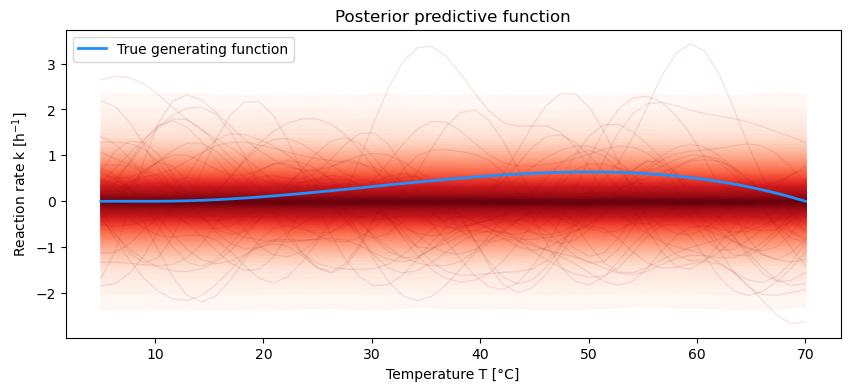

In [24]:
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

f_pred3 = az.extract(trace3.posterior_predictive, var_names="f_pred").transpose("sample", ...)
plot_gp_dist(ax, f_pred3, T_full[:, None])

ax.plot(T_full, k_full, color="dodgerblue", label="True generating function", linewidth=2)

ax.set_xlabel("Temperature T [°C]")
ax.set_ylabel("Reaction rate k [h$^{-1}$]")
ax.set_title("Posterior predictive function")
plt.legend();